<img src='https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSI-SAF_banner.png' align='right' width='100%'/>

<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_3a_OSI_SAF_wind_mapping_ASCAT.ipynb" target="_blank"><< Mapping examples of OSI SAF ASCAT wind products</a>

<font color="#138D75">**EUMETSAT OSI SAF Training Service**</font> <br>
**Copyright:** 2024 EUMETSAT <br>
**License:** MIT

<html>
  <div style="width:100%">
    <div style="float:left"><a href="https://mybinder.org/v2/git/https%3A%2F%2Fgitlab.eumetsat.int%2Feumetlab%2Foceans%2Focean-training%2Fsensors%2Flearn-osi-saf-wind/HEAD?labpath=1_OSI_SAF_wind_introductory%2F1_3_OSI_SAF_mapping_wind.ipynb"><img src="https://mybinder.org/badge_logo.svg" alt="Open in Binder"></a></div>
    <div style="float:left"><p>&emsp;</p></div>
  </div>
</html>

<div class="alert alert-block alert-success">
<h3>Learn OSI SAF wind: Introductory</h3></div>

<div class="alert alert-block alert-warning">
    
<b>PREREQUISITES </b>
    
The following modules are prerequisites for this notebook, and will retrieve the data required here.
  - **<a href="./1_1a_OSI_SAF_wind_data_access_Data_Store.ipynb" target="_blank">1_1_OSI_SAF_wind_FTP_data_access.ipynb</a>**

</div>
<hr>

# 1.3 Mapping examples of OSI SAF HY wind products

### Data used

| Dataset | EUMETSAT collection ID | OSI SAF website description | OSI SAF identifier |
|:-----------------:|:-----------------:|:-----------------:|:-----------------:|
| HY-2B 25 km wind vectors | EO:EUM:DAT:0537 | <a href="https://osi-saf.eumetsat.int/products/osi-114-a" target="_blank">Description</a> | OSI-114-a | 
| HY-2B 50 km wind vectors | EO:EUM:DAT:0537 | <a href="https://osi-saf.eumetsat.int/products/osi-114-b" target="_blank">Description</a> | OSI-114-b| 
| HY-2C 25 km wind vectors | EO:EUM:DAT:0539 | <a href="https://osi-saf.eumetsat.int/products/osi-115-a" target="_blank">Description</a> | OSI-115-a | 
| HY-2C 50 km wind vectors | EO:EUM:DAT:0539 | <a href="https://osi-saf.eumetsat.int/products/osi-115-b" target="_blank">Description</a> | OSI-115-b| 

### Learning outcomes

At the end of this notebook you will know;
* How to open HY Wind netcdf files
* Map HY winds using cartopy

<div class="alert alert-info" role="alert">
    
## <a id='TOC-TOP'></a>Contents

</div>
    
 1. [Setting Parameters](#section1)
 1. [Mapping a wind dataset with cartopy](#section2)

<hr>

We begin by importing all of the libraries that we need to run this notebook. If you have built your python using the environment file provided in this repository, then you should have everything you need. For more information on building environment, please see the repository **<a href="../README.md" target="_blank">README</a>**.

In [1]:
# library imports
import os                          # a library that allows us access to basic operating system commands
import xarray as xr                # a library that supports the use of multi-dimensional arrays in Python
import matplotlib as mpl           # a library for visualization
import matplotlib.pyplot as plt    # a library that supports plotting
import matplotlib.cm as mpl_cm     # a part of the plotting library that provides colour maps
import cartopy.crs as ccrs         # a mapping library that supports reprojection
import cartopy.feature as cfeature # a part of the mapping library that provides features such as coastlines
import cmocean                     # colormaps for ocean products
import numpy as np                 # a library that supports array manipulation
import urllib                      # a library that helps us read in remote resources from URLs
from PIL import Image              # a library that helps us plot images
import warnings                    # a library that controls python warnings
warnings.filterwarnings('ignore')

<div class="alert alert-info" role="alert">

## <a id='section0'></a>0. Supporting functions
[Back to top](#TOC-TOP)

</div>

Before we begin, we will define shorts functions.

The function name `mapping_wind` create a plot figure of wind and wind vector of the wind osi saf product available in the directory **dir** with a specific output projection.
It is possible to chose the wind plot type : \
* quiver_no_colormap : plot colored wind quiver vector in function of wind speed
* barbs_no_colormap : plot colored wind barbs vector in function of wind speed
* quiver_colormap : plot black quiver for wind dir with a color map for wind speed
* barbs_colormap : plot black barbs for wind dir with a color map for wind speed

In [6]:
def mapping_wind(directory, output_projection, cmap, stride=1, type='quiver_no_colormap', title="", region=None): 
    """
    Function to map Wind osi saf products. 

    Args:
        dir (string)        : the directory where files are
        output_projection   : the output projection to plot map
        cmap                : color palette
        stride (int)        : select data
        type (string)       : type of wind plot
        title (string)      : title of the plot
        region (list)       : the region to zoom in. If not region is given, plot a global map
        
    Returns:
        im                  : the plotting figure
    """
    
    # set data projection
    data_projection=ccrs.PlateCarree()

    # define plot carateristics
    ax = plt.axes([0.1,0.1,0.75,0.85], projection=output_projection)
    ax.set_global()
    ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
    ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
    ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
    ax.coastlines()    # Add coastline
    # Select region to zooming 
    if region : 
        ax.set_extent(region, crs=output_projection)
        scale = 500
    else :
        ax.set_global()
        scale = None

    # Add title
    plt.title(title, fontsize=18)
    
    # open and plot osi saf netcdf wind files
    for filename in os.listdir(directory):
        if filename.endswith(".nc"):
            nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
            lat = nc.variables['lat'][:]    
            lon = nc.variables['lon'][:]
            wind_speed = nc.variables['wind_speed'][:]
            wind_dir = nc.variables['wind_dir'][:]
            wvc_quality_flag  = nc.variables['wvc_quality_flag'][:]
            nc.close()

            # plotting wind barbs in cartopy requires u and v and components.
            u = np.full_like(lat,0)
            v = np.full_like(lat,0)
            lat = np.where(np.isnan(lat), 0, lat)
            lon = np.where(np.isnan(lon), 0, lon)

            u[:,:] = wind_speed * np.cos(np.radians(90 - wind_dir[:,:]))
            v[:,:] = wind_speed * np.sin(np.radians(90 - wind_dir[:,:]))

            # plotting wind Arrows with no wind speed colormap
            if type == 'quiver_no_colormap':
                im = ax.quiver(lon[::stride,::stride], lat[::stride,::stride], u[::stride,::stride], v[::stride,::stride], wind_speed[::stride,::stride], transform=data_projection, 
                    cmap=cmap, scale=scale)
            # plotting wind Arrows with wind speed colormap
            elif type == 'quiver_colormap':
                im = ax.contourf(lon,lat,wind_speed, np.arange(0,20,0.05), transform=data_projection, cmap=cmap)
                im = ax.quiver(lon[::stride,::stride], lat[::stride,::stride], u[::stride,::stride], 
                                v[::stride,::stride], transform=data_projection, 
                                color = 'black', scale=scale)
            # plotting wind barbs with no wind speed colormap
            elif type == 'barbs_no_colormap':
                im = ax.barbs(lon[::stride,::stride], lat[::stride,::stride], u[::stride,::stride], 
                            v[::stride,::stride], wind_speed[::stride,::stride], cmap=cmap, transform=data_projection)
            # plotting wind barbs with wind speed colormap
            elif type == 'barbs_colormap':
                im = ax.contourf(lon,lat,wind_speed, np.arange(0,20,0.05), transform=data_projection, cmap=cmap)
                im = ax.barbs(lon[::stride,::stride], lat[::stride,::stride], u[::stride,::stride], 
                            v[::stride,::stride], transform=data_projection, 
                            color = 'black')
            else :
                print(f'{type} not recognize') 
                
            im.set_clim(0,25)
    return im

The function name `add_colorbar` create a colorbar of the image im.

In [9]:
def add_colorbar(im, fig, orientation, cmap, discrete=False, extend='neither'):
    """
    Function to add a colormap. 

    Args:
        im                         : image
        fig                        : figure
        orientation (string)       : the orientation of colorbar (horizontal or vertical)
        cmap                       : color palette
        dicrete (bool)             : add discrete color
        extend                     : extension type of the colorbar (neither, max, min or both) 

    """
    
    if orientation == 'horizontal':
        axc = fig.add_axes((0.1,0.1,0.75,0.02))
        ax = fig.add_axes([0.43,0.12,0.1,0.05], anchor='S', zorder=-1 )
    else :
        axc = fig.add_axes((0.85,0.2,0.02,0.85))
        ax = fig.add_axes([0.8,.1,0.1,0.05], anchor='S', zorder=-1 )

    if discrete:
        bounds = range(int(im.get_clim()[0]),int(im.get_clim()[1]))
        norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend, norm=norm, spacing='proportional', ticks=bounds, boundaries=bounds)
    else:
        cb = plt.colorbar(im, orientation=orientation, cax=axc, extend=extend)
    
    url = "https://gitlab.eumetsat.int/eumetlab/oceans/ocean-training/tools/frameworks/-/raw/main/img/OSISAF_Name_Colour.png"
    logo = np.array(Image.open(urllib.request.urlopen(url)))
    
    ax.imshow(logo)
    ax.axis('off')
    
    cb.set_label('Wind Speed [m/s]', fontsize=18)
    cb.ax.tick_params(labelsize=14)

<div class="alert alert-info" role="alert">

## <a id='section1'></a>1. Setting Parameters
[Back to top](#TOC-TOP)

</div>

Choose a colormap for your data set. You can find more information on matplotlib colormaps <a href="https://matplotlib.org/stable/tutorials/colors/colormaps.html" target="_blank">here</a>. 

In [13]:
cmap = mpl_cm.get_cmap('RdYlBu_r')

We also recommend you have a look at <a href=" https://matplotlib.org/cmocean/" target="_blank">cmocean colormaps</a> .

In [16]:
# another choice could be
#cmap = cmocean.cm.speed

<div class="alert alert-info" role="alert">

## <a id='section2'></a>2. Mapping a wind dataset with cartopy
[Back to top](#TOC-TOP)

</div>

#### HY-2B 25 km wind 

Select the directory where the data you want to plot is available.

In [21]:
directory = os.path.join(os.getcwd(), 'products', 'hy_2b', '25')

##### World map mapping
Let's start by visualising data with a world map

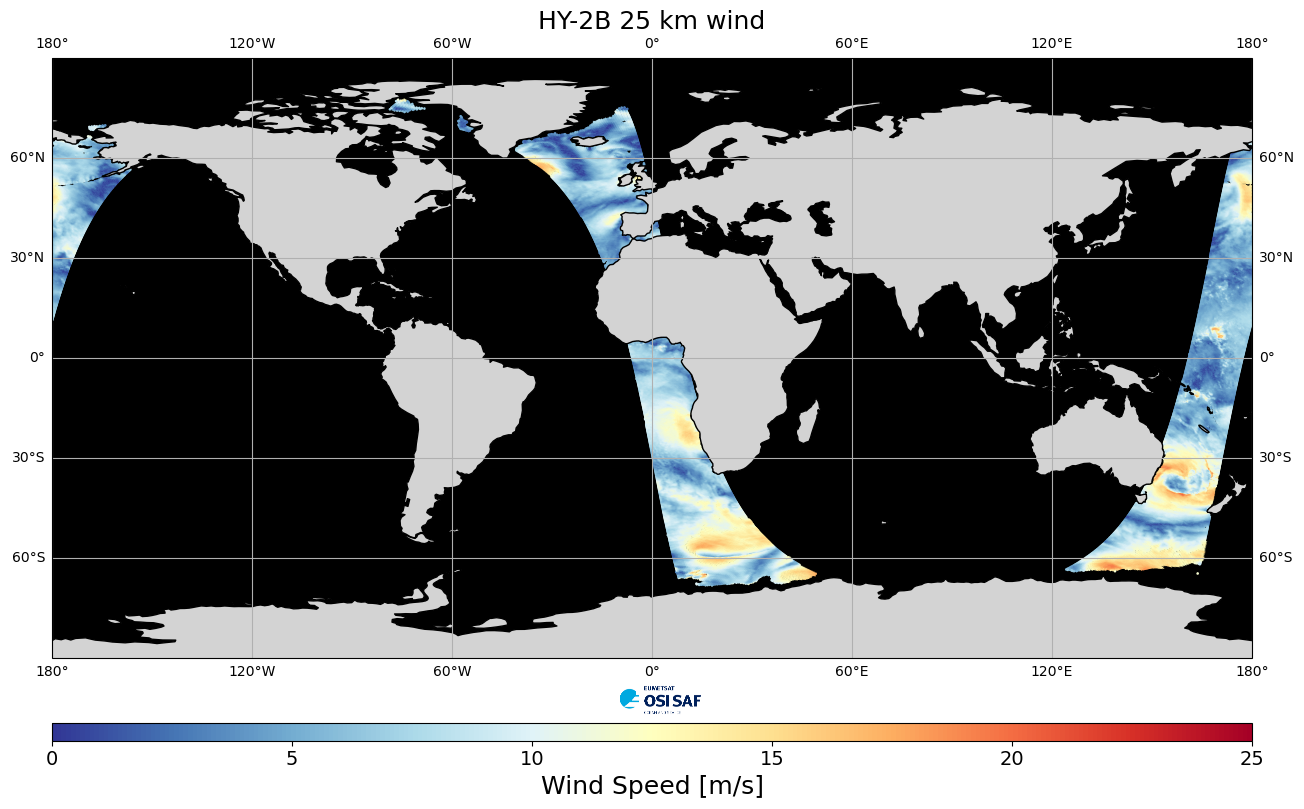

In [24]:
# For HY_2B wind 25 km
fig = plt.figure(figsize=(16,9))

# request output projection
output_projection=ccrs.PlateCarree()

# Map
im = mapping_wind(directory, 
                  output_projection, 
                  cmap,
                  type='quiver_no_colormap', 
                  title="HY-2B 25 km wind", 
                  region=None)

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

##### Other projection
Let's try an other map projection

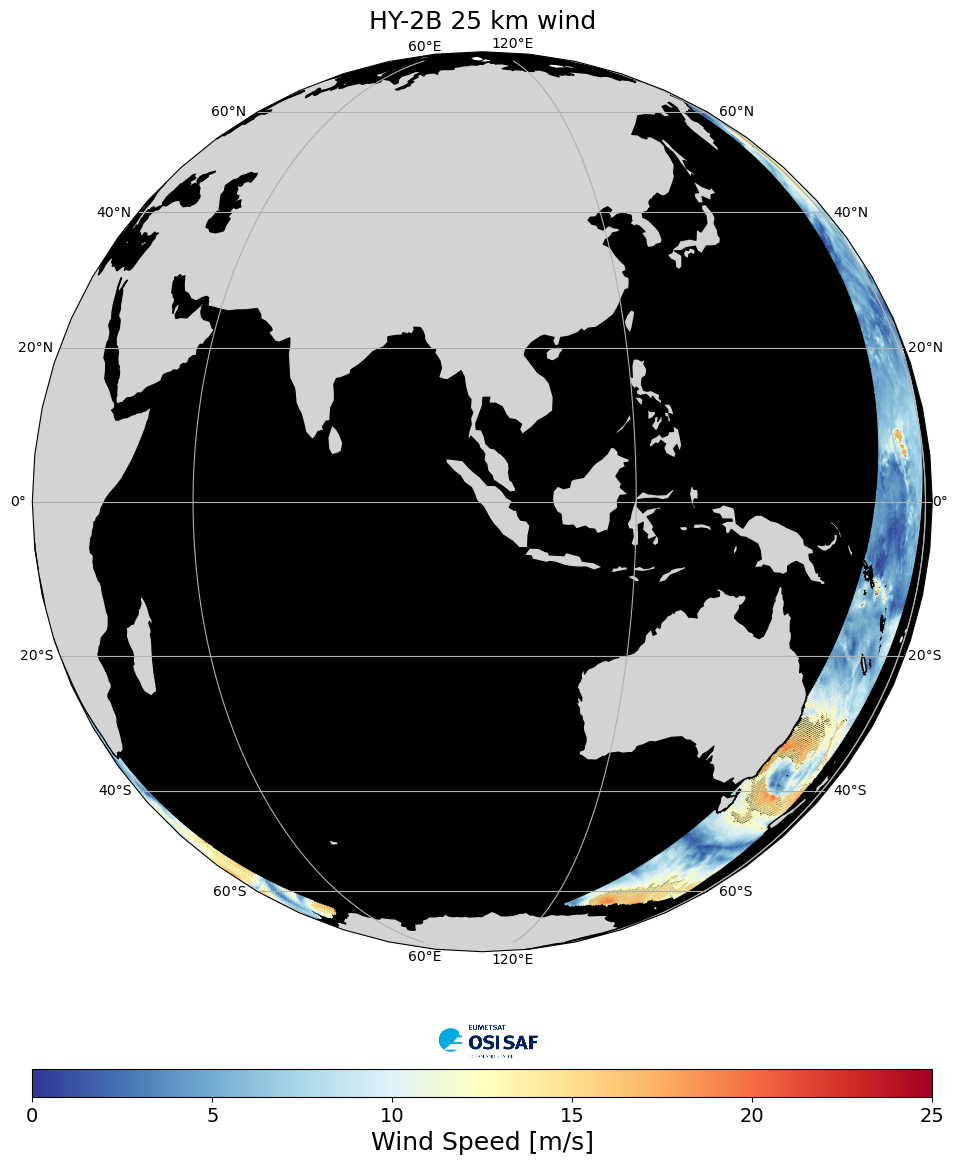

In [27]:
# For HY-2B wind 25 km
fig = plt.figure(figsize=(12,14))

# request output projection
output_projection=ccrs.Orthographic(100,)

# Map
im = mapping_wind(directory, 
                  output_projection, 
                  cmap,
                  type='quiver_no_colormap', 
                  title="HY-2B 25 km wind", 
                  region=None)

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

##### Zoom in
Let's zoom in a specific area 

Select the geographical area

In [35]:
# Set area
lon_min = 130
lon_max = 170
lat_min = -30
lat_max = -60

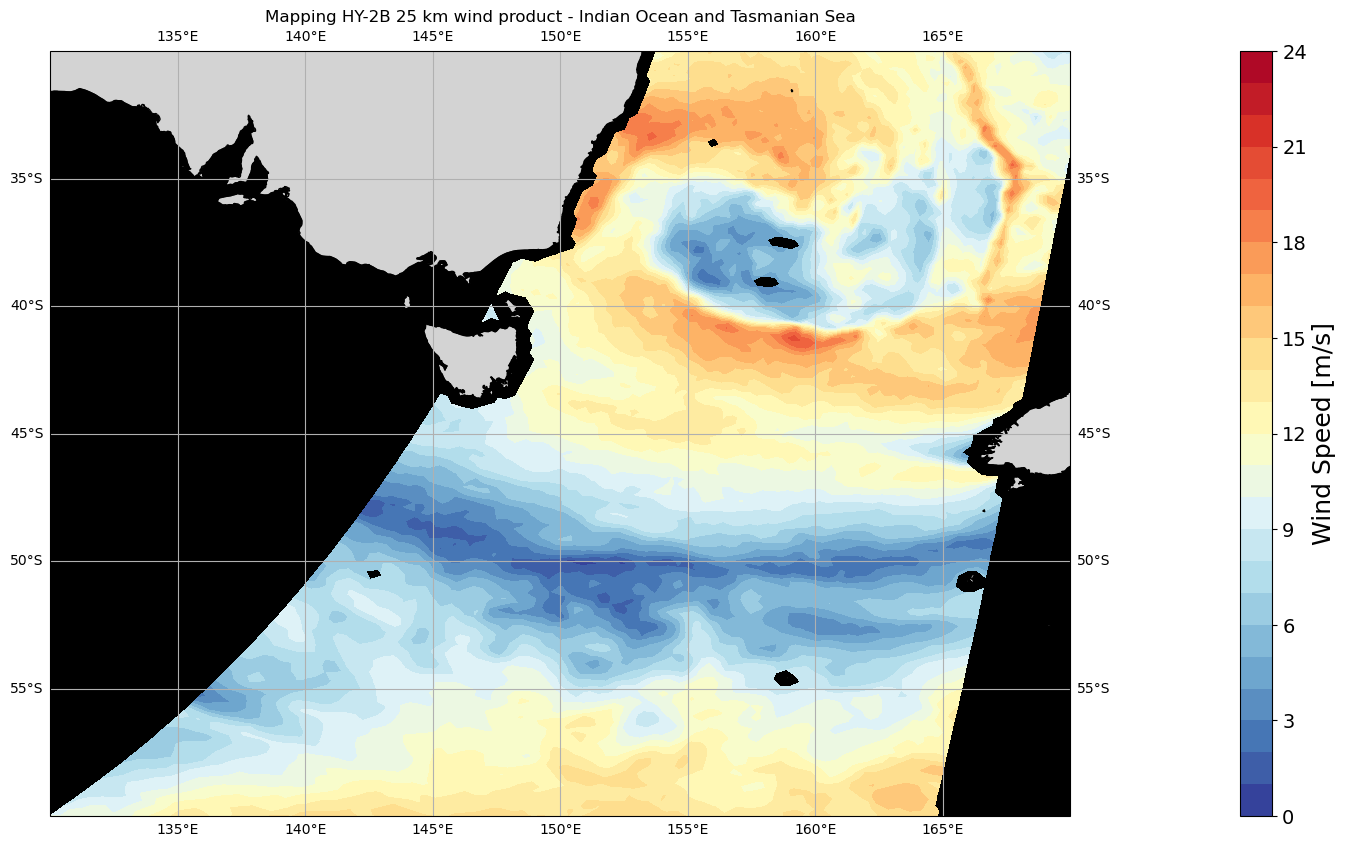

In [37]:
# For HY-2B 25 km wind
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_extent([lon_min,lon_max,lat_min,lat_max], crs=data_projection)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline
ax.coastlines('10m')
#Add title
plt.title("Mapping HY-2B 25 km wind product - Indian Ocean and Tasmanian Sea")

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        nc.close()
        
        wind_speed = np.ma.masked_where(lon<1, wind_speed)
        
        # plotting wind speed
        im = ax.contourf(lon,lat,wind_speed, range(0,25), transform=data_projection, cmap=cmap)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

#### HY-2B 50 km wind 

Select the directory where the data you want to plot is available.

In [41]:
directory = os.path.join(os.getcwd(), 'products', 'hy_2b', '50')

##### World map mapping
Let's start by visualising data with a world map

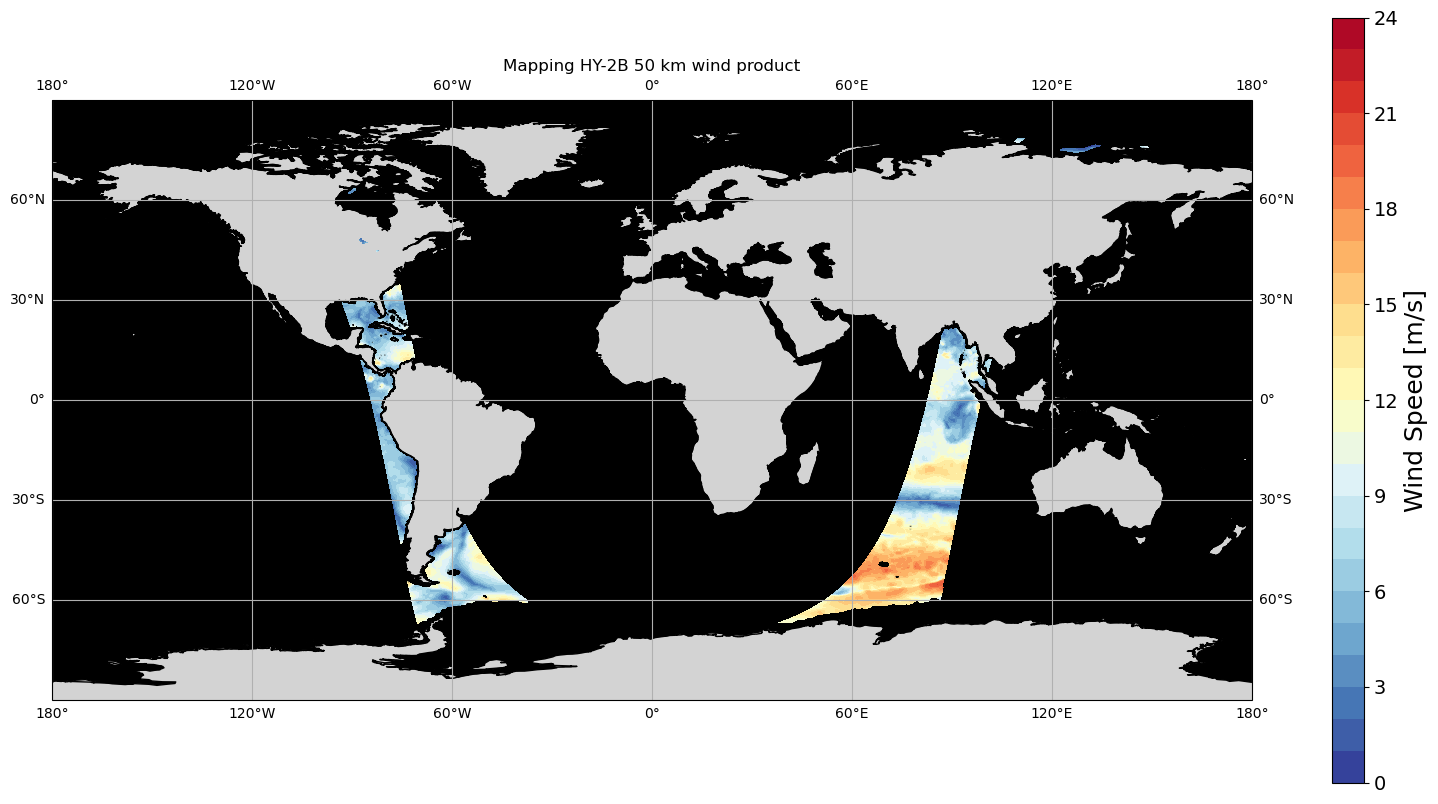

In [44]:
# For HY-2B 50 km wind
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_global()
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline
ax.coastlines('10m')
#Add title
plt.title("Mapping HY-2B 50 km wind product")

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        nc.close()
        
        #Debug map
        wind_speed = np.ma.masked_where(lon<2, wind_speed)
        
        # plotting wind speed
        im = ax.contourf(lon,lat,wind_speed, range(0,25), transform=data_projection, cmap=cmap)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

##### Other map projection
Let's try an other projection

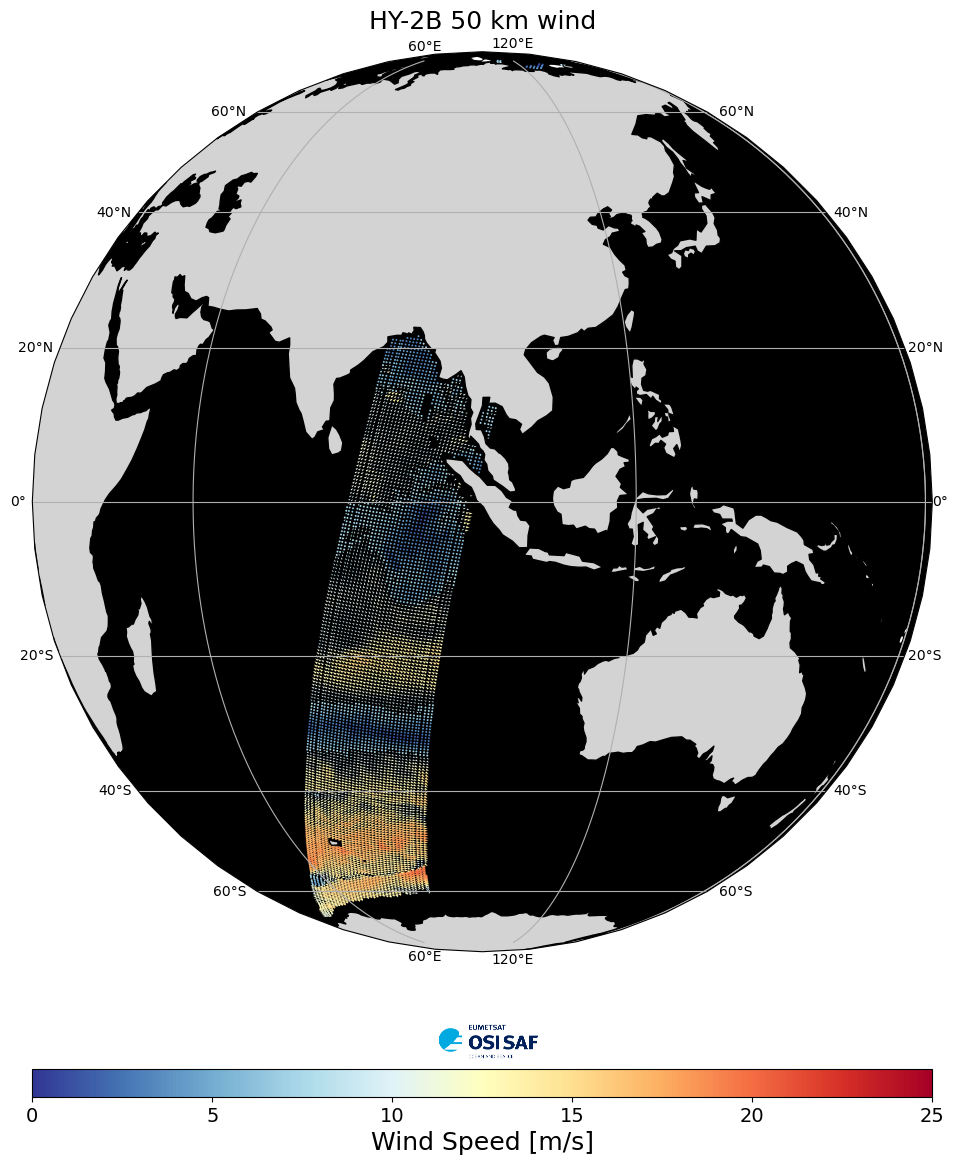

In [47]:
# For HY-2B wind 50 km
fig = plt.figure(figsize=(12,14))

# request output projection
output_projection=ccrs.Orthographic(100,)

# Map
im = mapping_wind(directory, 
                  output_projection, 
                  cmap,
                  type='quiver_no_colormap', 
                  title="HY-2B 50 km wind", 
                  region=None)

# Adding a colorbar
add_colorbar(im, fig, orientation='horizontal', cmap=cmap)

##### Zoom in
Let's zoom in a specific area

Select the geographical area

In [67]:
# Set area
lon_min = 50
lon_max = 90
lat_min = -30
lat_max = -60

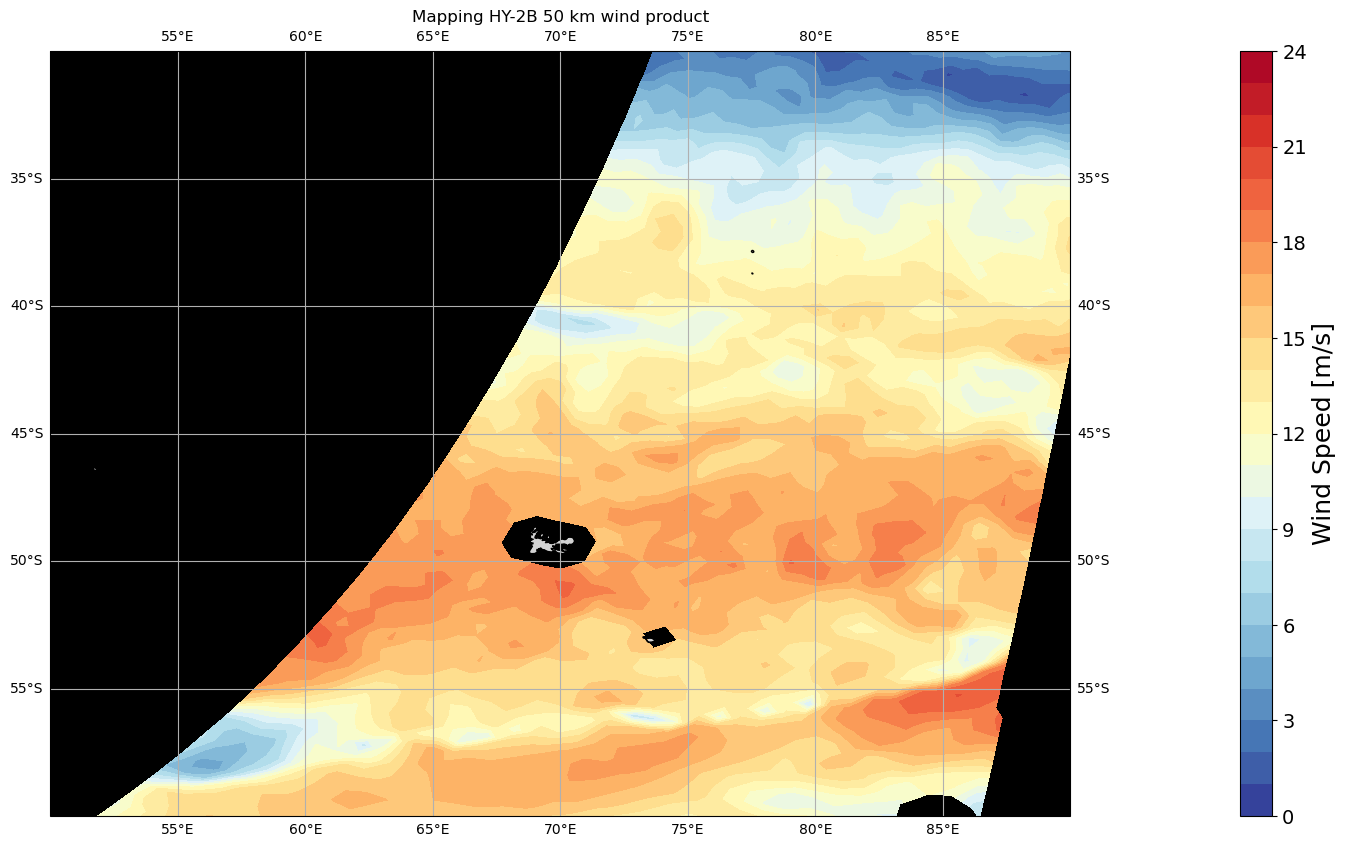

In [69]:
# For HY-2B 50 km wind
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_extent([lon_min,lon_max,lat_min,lat_max], crs=data_projection)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline
ax.coastlines('10m')
#Add title
plt.title("Mapping HY-2B 50 km wind product")

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        nc.close()
        
        wind_speed = np.ma.masked_where(lon<1, wind_speed)
        
        # plotting wind speed
        im = ax.contourf(lon,lat,wind_speed, range(0,25), transform=data_projection, cmap=cmap)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

#### HY-2C 25 km wind 

Select the directory where the data you want to plot is available.

In [73]:
directory = os.path.join(os.getcwd(), 'products', 'hy_2c', '25')

##### World map mapping 
Let's start by visualising data with a world map

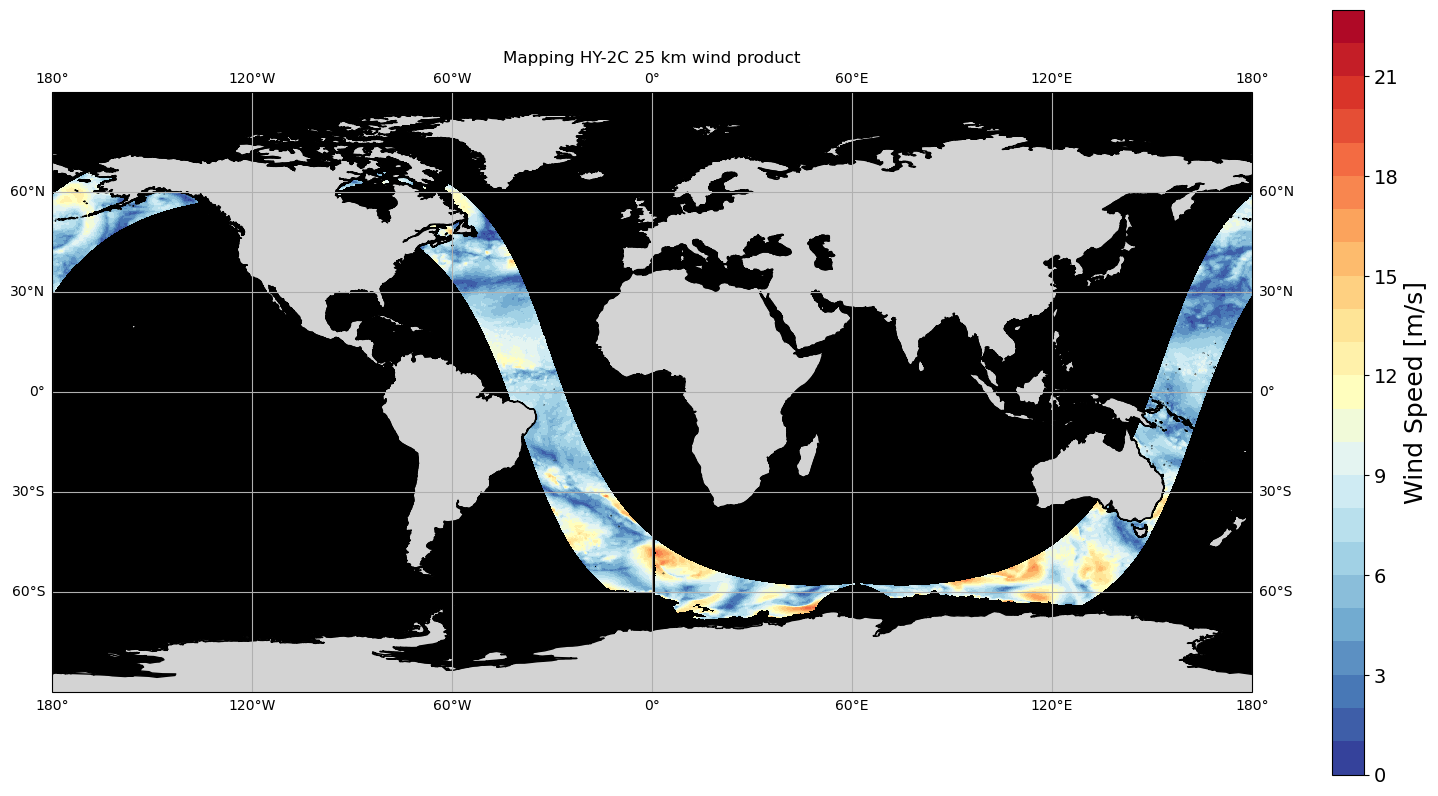

In [76]:
# For HY-2C 25 km wind
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_global()
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline
ax.coastlines('10m')
#Add title
plt.title("Mapping HY-2C 25 km wind product")

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        nc.close()

        wind_speed = np.ma.masked_where(lon<1, wind_speed)
        
        # plotting wind speed
        im = ax.contourf(lon,lat,wind_speed, range(0,24), transform=data_projection, cmap=cmap)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

##### Other map projection
Let's try an other projection

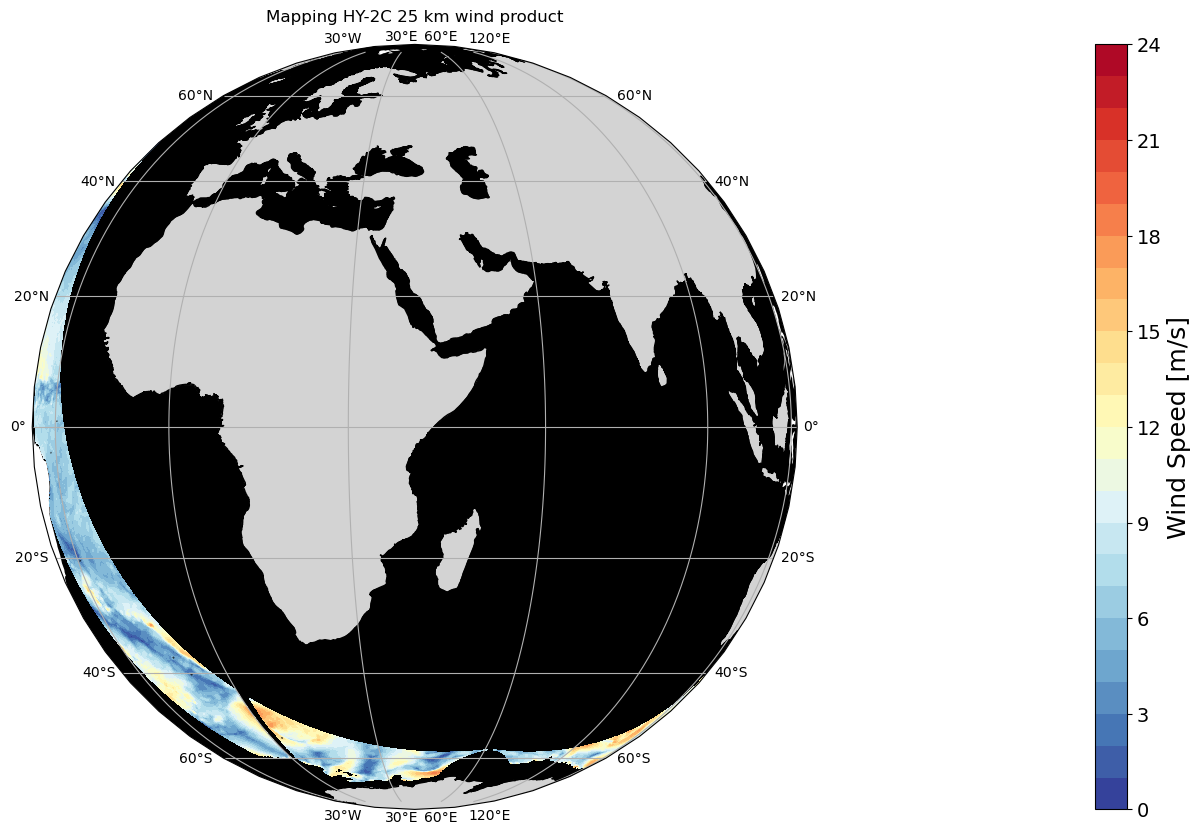

In [79]:
# For HY-2C 25 km wind
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.Orthographic(central_longitude=40,)

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_global()
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline
ax.coastlines('10m')
#Add title
plt.title("Mapping HY-2C 25 km wind product")

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        nc.close()
        
        wind_speed = np.ma.masked_where(lon<2, wind_speed)
        
        # plotting wind speed
        im = ax.contourf(lon,lat,wind_speed, range(0,25), transform=data_projection, cmap=cmap)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

##### Zoom in
Let's zoom into a specific area

Select the geographical area

In [91]:
# Set area
lon_min = -80
lon_max = -50
lat_min = 50
lat_max = 70

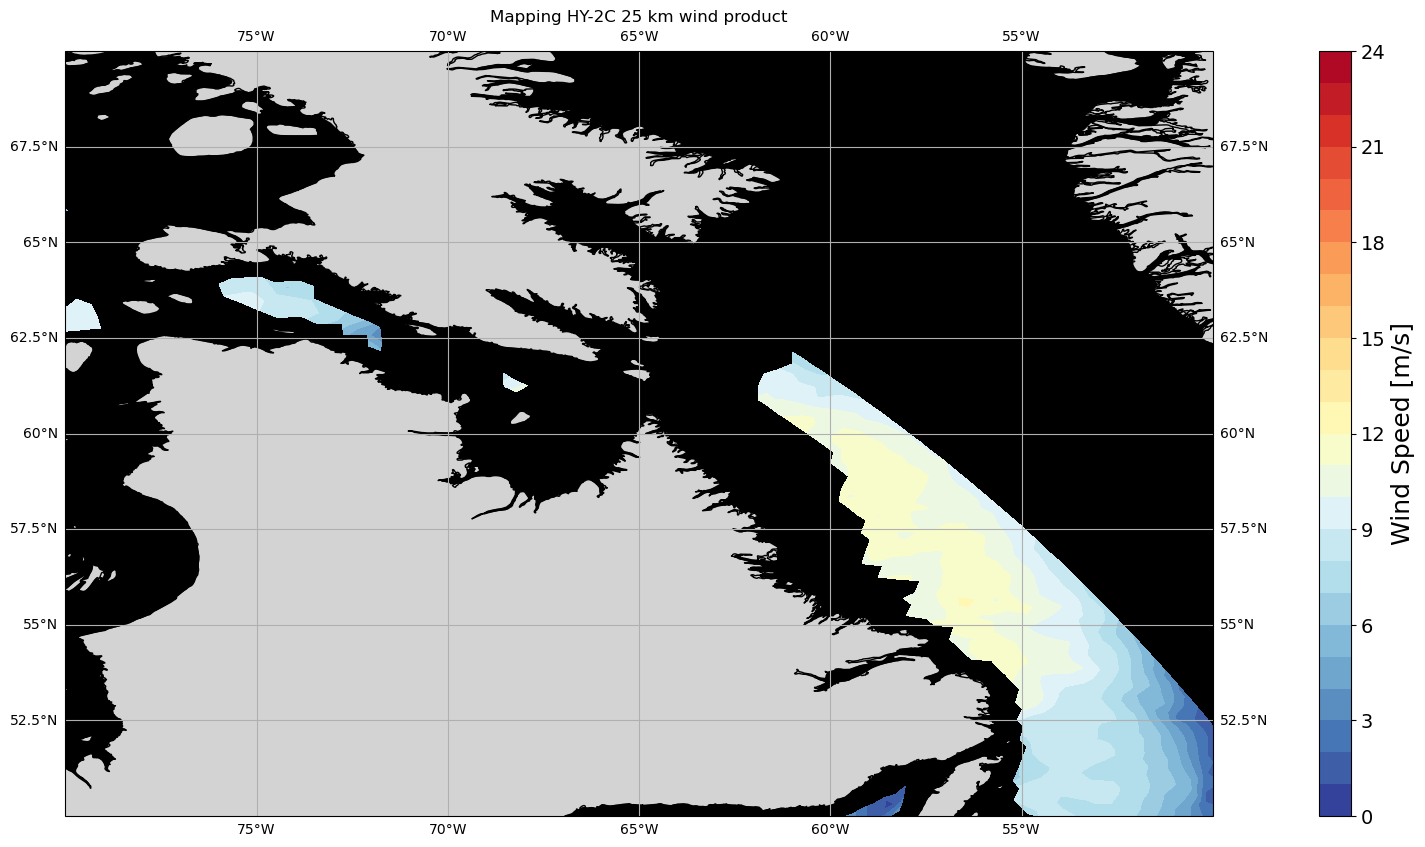

In [93]:
# For HY-2C 25 km wind
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_extent([lon_min,lon_max,lat_min,lat_max], crs=data_projection)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline
ax.coastlines('10m')
#Add title
plt.title("Mapping HY-2C 25 km wind product")

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        nc.close()
        
        wind_speed = np.ma.masked_where(lon<1, wind_speed)
        
        # plotting wind speed
        im = ax.contourf(lon,lat,wind_speed, range(0,25), transform=data_projection, cmap=cmap)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

#### HY-2C 50 km wind 

Select the directory where the data you want to plot is available.

In [97]:
directory = os.path.join(os.getcwd(), 'products', 'hy_2c', '50')

##### World map mapping 
Let's start by visualising data with a world map

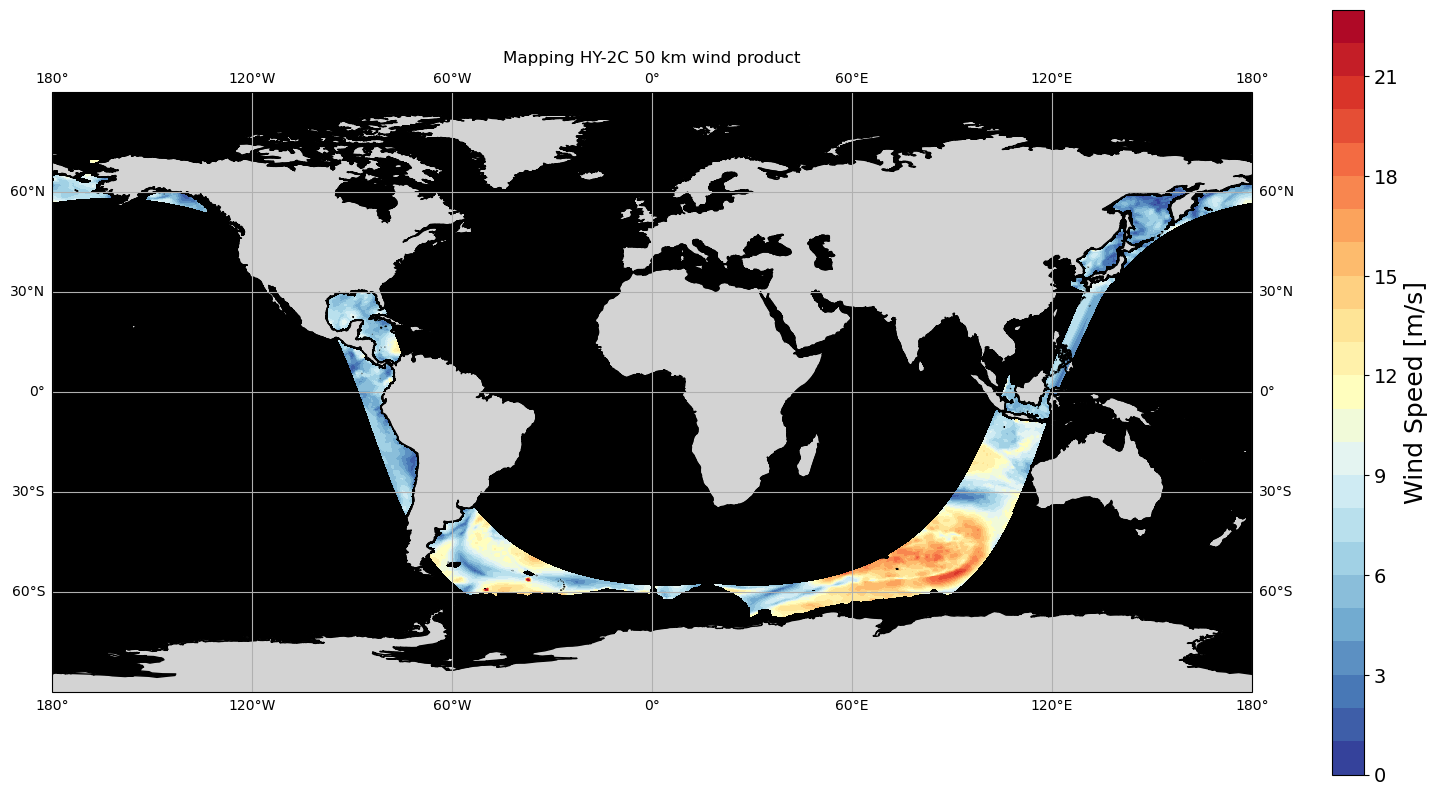

In [100]:
# For HY-2C 50 km wind
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_global()
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline
ax.coastlines('10m')
#Add title
plt.title("Mapping HY-2C 50 km wind product")

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        nc.close()

        wind_speed = np.ma.masked_where(lon<1, wind_speed)
        
        # plotting wind speed
        im = ax.contourf(lon,lat,wind_speed, range(0,24), transform=data_projection, cmap=cmap)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

##### Other map projection
Let's try an other projection

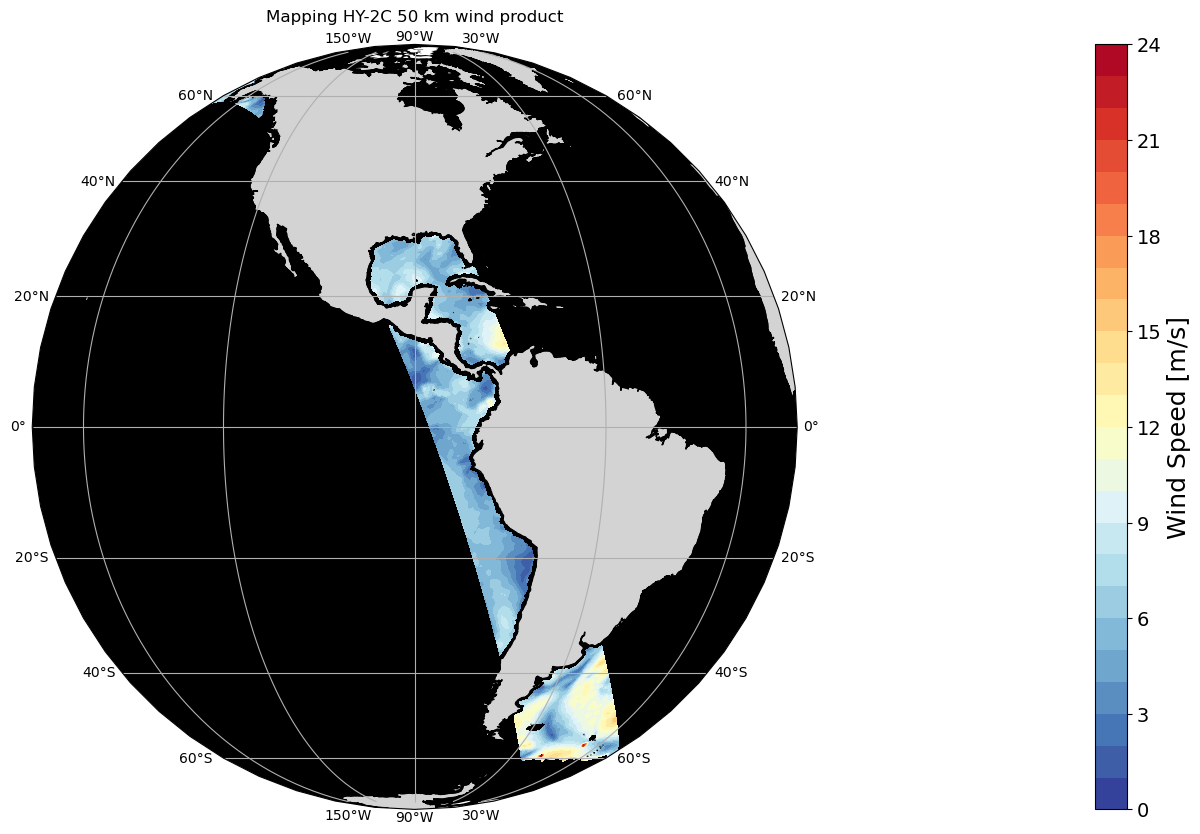

In [123]:
# For HY-2C 25 km wind
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.Orthographic(central_longitude=-90)

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_global()
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=1, facecolor='lightgrey')  # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline
ax.coastlines('10m')
#Add title
plt.title("Mapping HY-2C 50 km wind product")

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        nc.close()
        
        wind_speed = np.ma.masked_where(lon<2, wind_speed)
        
        # plotting wind speed
        im = ax.contourf(lon,lat,wind_speed, range(0,25), transform=data_projection, cmap=cmap)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
bounds = range(0,32)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

##### Zoom in
Let's zoom into a specific area

Select the geographical area

In [133]:
# Set area
lon_min = -170
lon_max = -140
lat_min = 50
lat_max = 70

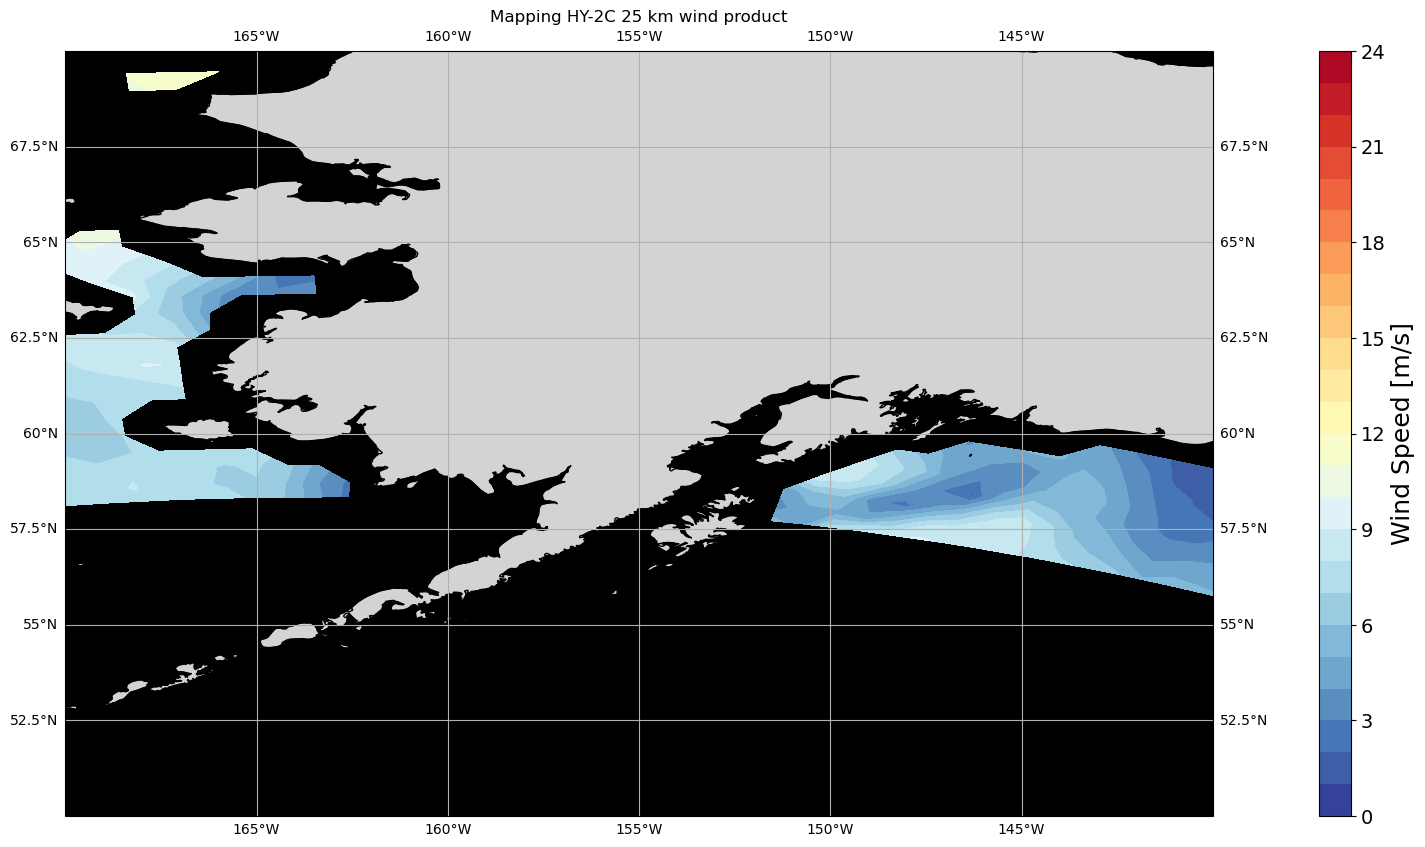

In [135]:
# For HY-2C 50 km wind
fig = plt.figure(figsize=(16,9))

# set data projection and request output projection
data_projection=ccrs.PlateCarree()
output_projection=ccrs.PlateCarree()

# define plot carateristics
ax = plt.axes([0.05,0.05,0.75,0.85], projection=output_projection)
ax.set_extent([lon_min,lon_max,lat_min,lat_max], crs=data_projection)
ax.add_feature(cfeature.OCEAN, zorder=0, facecolor='black') # Change color of ocean
ax.add_feature(cfeature.LAND, zorder=0, facecolor='lightgrey')  # Change color of land
ax.gridlines(draw_labels=True)   # Add grid line with latitude and logitude label 
ax.coastlines()    # Add coastline
ax.coastlines('10m')
#Add title
plt.title("Mapping HY-2C 25 km wind product")

# open and plot osi saf netcdf wind files
for filename in os.listdir(directory):
    if filename.endswith(".nc"):
        nc = xr.open_dataset(os.path.join(directory, filename), decode_times=False)
        lat = nc.variables['lat'][:]    
        lon = nc.variables['lon'][:]
        wind_speed = nc.variables['wind_speed'][:]
        nc.close()
        
        wind_speed = np.ma.masked_where(lon<1, wind_speed)
        
        # plotting wind speed
        im = ax.contourf(lon,lat,wind_speed, range(0,25), transform=data_projection, cmap=cmap)

# Adding a colorbar
axc = fig.add_axes((0.85,0.05,0.02,0.85))
cb = plt.colorbar(im, orientation='vertical', cax=axc)
cb.set_label('Wind Speed [m/s]', fontsize=18)
cb.ax.tick_params(labelsize=14)

<hr>
<a href="../Index.ipynb" target="_blank"><< Index</a>
<br>
<a href="./1_2_OSI_SAF_wind_file_structure.ipynb" target="_blank"><< Exploring OSI SAF wind product structure</a>
<hr>
<a href="https://gitlab.eumetsat.int/eumetlab/ocean">View on GitLab</a> | <a href="https://training.eumetsat.int/">EUMETSAT Training</a> | <a href=mailto:ops@eumetsat.int>Contact helpdesk for support </a> | <a href=mailto:training@eumetsat.int>Contact our training team to collaborate on and reuse this material</a></span></p>